# EDA that makes sense for the *Child Mind Institute — Problematic Internet Use* competition

This notebook shows
- a first analysis of the data
- how to cross-validate a model
- that regression models are better than classification models in this competition, and
- how to tune the thresholds for rounding the regression output.

The notebook uses [polars DataFrames](https://pola.rs/). If you are more fluent with pandas than with polars, this is an opportunity to get to know polars, which is often more efficient than pandas.

In [1]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import numpy as np
import seaborn as sns
import lightgbm
from colorama import Fore, Style
from scipy.optimize import minimize

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay

target_labels = ['None', 'Mild', 'Moderate', 'Severe']

In [2]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
str,enum,i64,i64,enum,i64,enum,f64,f64,f64,f64,i64,i64,i64,enum,i64,i64,i64,enum,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,enum,i64,f64,f64,…,f64,f64,f64,f64,f64,enum,f64,enum,f64,enum,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,enum,i64,i64,enum,i64,i64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,21.0352,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,30.4041,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1
"""0016bb22""","""Spring""",18,1,"""Summer""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,"""Summer""",1.04,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""","""Fall""",13,0,"""Spring""",60,"""Fall""",16.36246,59.5,82.4,null,71,70,104,null,null,null,null,"""Fall""",16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,"""Fall""",3,4.52277,16.3642,…,33.3709,17.9797,66.2889,29.779,52.832,null,null,"""Winter""",3.26,"""Winter""",3,3,3,2,3,2,2,2,2,1,2,0,2,0,1,0,2,1,1,0,32,"""Winter""",35,50,"""Fall""",1,1
"""ffa9794a""","""Winter""",10,0,null,null,"""Spring""",18.764678,53.5,76.4,27.0,60,78,118,null,null,null,null,"""Spring""",0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,"""Spring""",null,null,null,…,null,nu

The training dataset has 3960 samples (children who participate in the study) and 80 features (not counting the `id` column and the target `sii`). According to the documentation, the full test set comprises about 3800 instances, of which 1400 are public and 2400 private.

# Missing values

All columns have a substantial proportion of missing values, except `id` (not surprisingly) and the three basic demographic columns for sex, age and season of enrollment. Even the target `sii` has missing values:

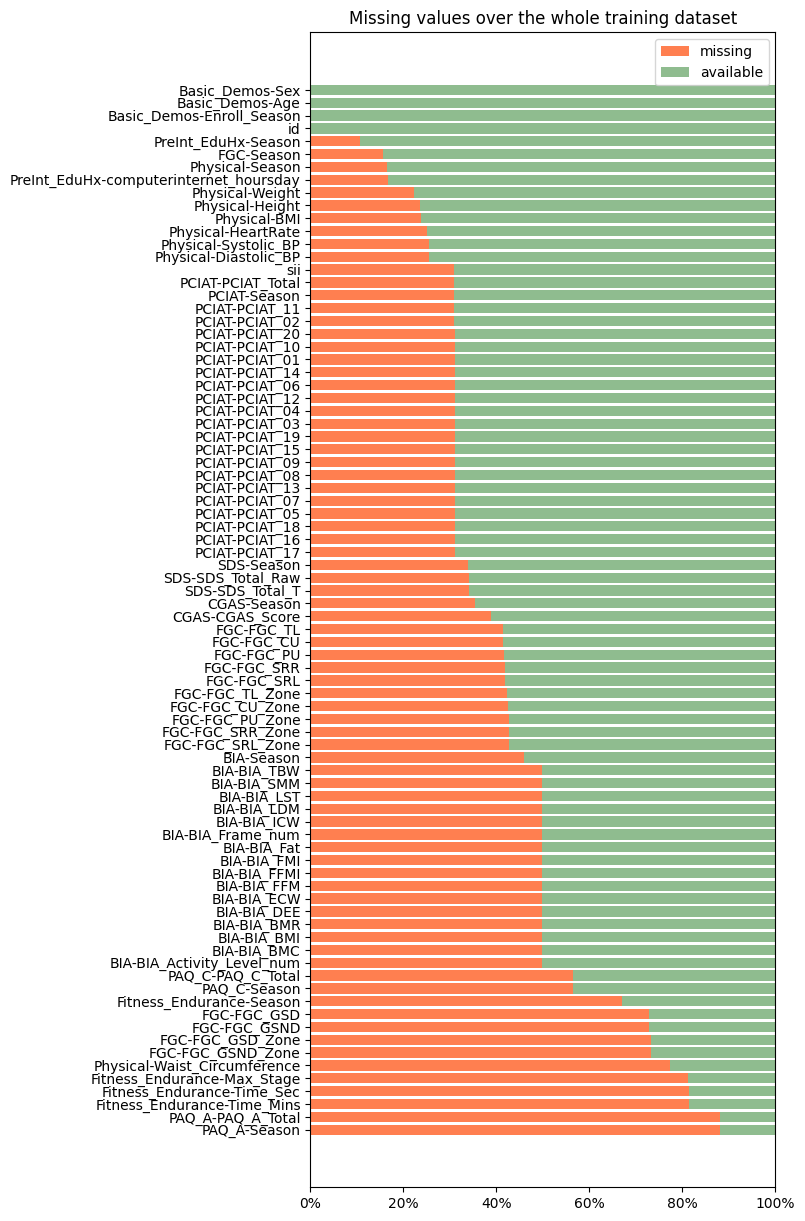

In [3]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title('Missing values over the whole training dataset')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

If we count the missing feature values only for the usable part of the training dataset (samples are usable for supervised training if the target is known), the chart looks slightly different:

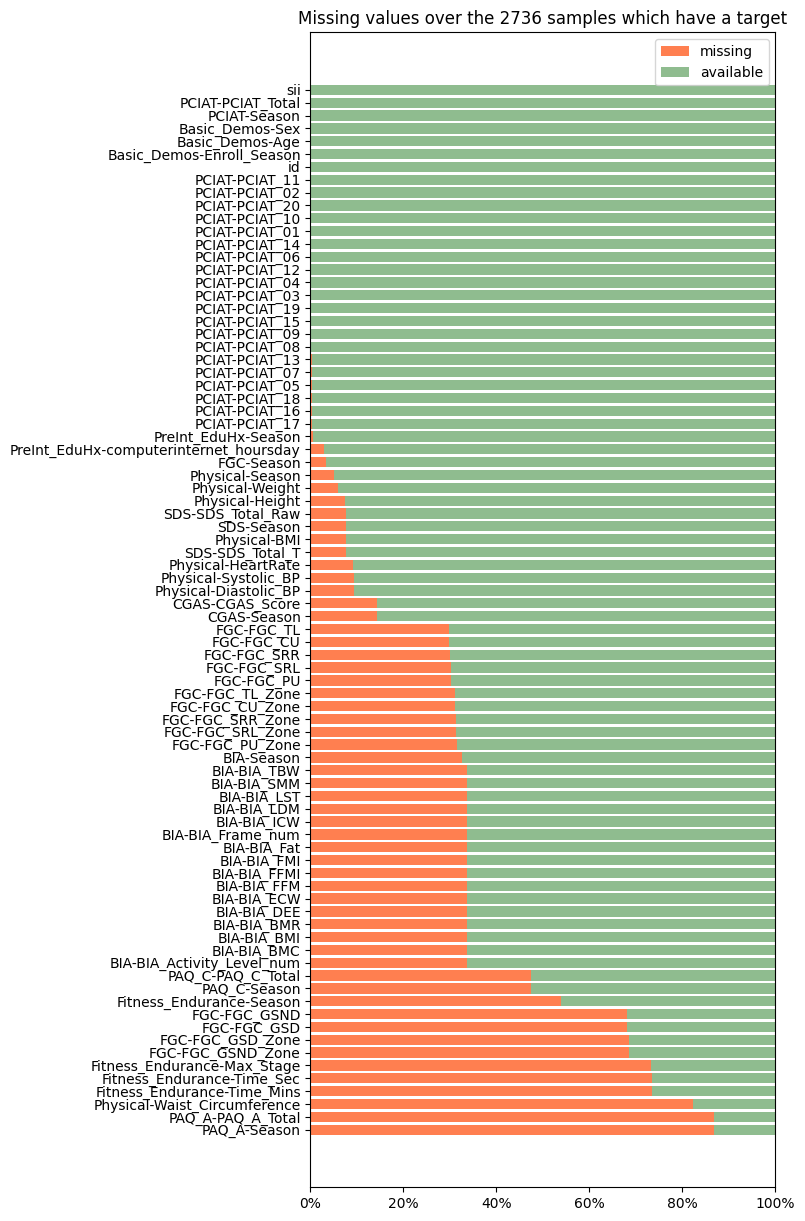

In [4]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)
plt.figure(figsize=(6, 15))
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')
plt.barh(np.arange(len(missing_count)), 
         1 - missing_count.get_column('null_ratio'),
         left=missing_count.get_column('null_ratio'),
         color='darkseagreen', label='available')
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)
plt.legend()
plt.show()

# The target

The target `sii` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score:

In [5]:
# print(train.select(pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null()).to_series().mean())

(train
 .select(pl.col('PCIAT-PCIAT_Total'))
 .group_by(train.get_column('sii'))
 .agg(pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),
      pl.col('PCIAT-PCIAT_Total').len().alias('count'))
 .sort('sii')
)

sii,PCIAT-PCIAT_Total min,PCIAT-PCIAT_Total max,count
i64,i64,i64,u32
null,null,null,1224
0,0,30,1594
1,31,49,730
2,50,79,378
3,80,93,34


The test dataset doesn't have any PCIAT columns (otherwise predictions would be trivial).

**Insight:**
1. We should focus on predicting the target from all other features except the PCIAT results.
2. We know the target only for two thirds of the samples. The samples without target can perhaps be used for semi-supervised learning.
3. We can directly predict `sii` (this is the value we have to submit), or we can predict `PCIAT-PCIAT_Total` and then transform this prediction to a `sii` prediction for submission. As `PCIAT-PCIAT_Total` is more granular and informative than `sii`, training to predict `PCIAT-PCIAT_Total` has the potential to produce a better model.

In [6]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


# Demographics

The study participants are between 5 and 22 years old. There are twice as many boys as girls.

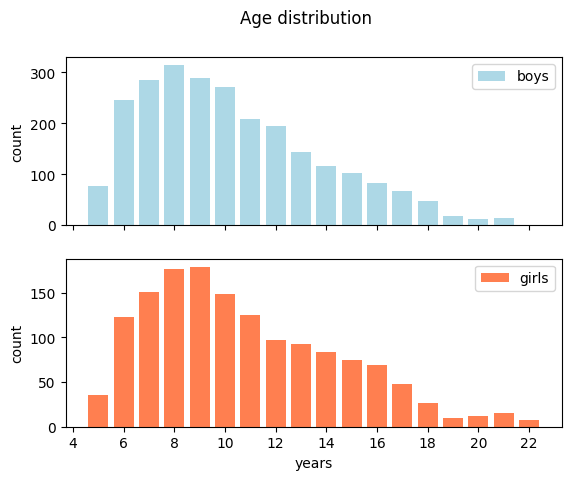

In [7]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

The four seasons of enrollment have similar frequencies:

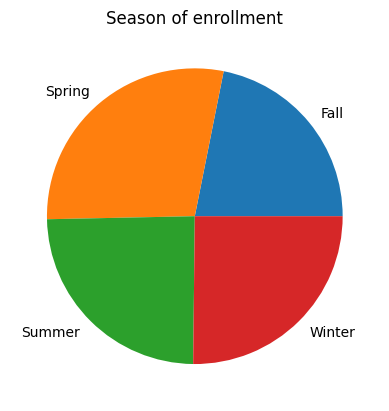

In [8]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

Boys have a slightly higher risk of internet addiction than girls:

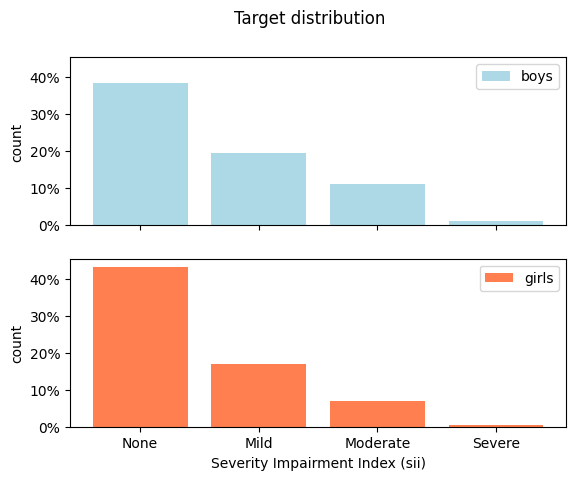

In [9]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

# A look at selected other features

Some children had their body–mass index measured twice in the study. Comparing the two reported values gives an impression of data quality:


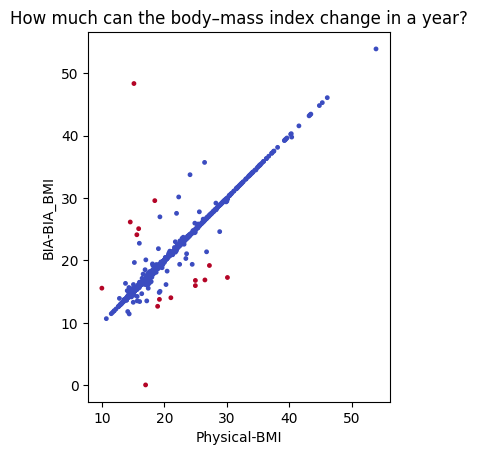

In [10]:
bmi_ratio = train.select(pl.col('Physical-BMI') / pl.col('BIA-BIA_BMI')).to_series()
color = (bmi_ratio < 0.7) | (bmi_ratio > 1.3) # red if difference > 30 %

plt.scatter(train.get_column('Physical-BMI'),
            train.get_column('BIA-BIA_BMI'),
            s=6,
            cmap='coolwarm',
            c=color)
plt.gca().set_aspect('equal')
plt.xlabel('Physical-BMI')
plt.ylabel('BIA-BIA_BMI')
plt.title('How much can the body–mass index change in a year?')
plt.show()

Systolic blood pressure should always be higher than diastolic:

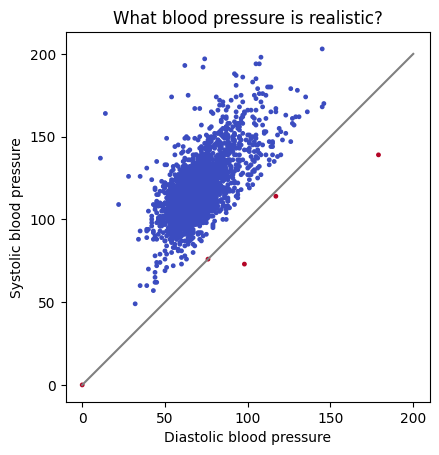

In [11]:
color = train.get_column('Physical-Systolic_BP') <= train.get_column('Physical-Diastolic_BP')

plt.scatter(train.get_column('Physical-Diastolic_BP'),
            train.get_column('Physical-Systolic_BP'),
            s=6,
            cmap='coolwarm',
            c=color)
plt.gca().set_aspect('equal')
plt.plot([0, 200], [0, 200], color='gray')
plt.xlabel('Diastolic blood pressure')
plt.ylabel('Systolic blood pressure')
plt.title('What blood pressure is realistic?')
plt.xticks(np.linspace(0, 200, 5))
plt.yticks(np.linspace(0, 200, 5))
plt.show()

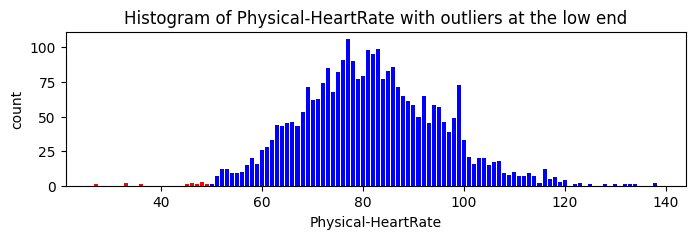

In [12]:
vc = train.get_column('Physical-HeartRate').value_counts()
color = np.where(vc.get_column('Physical-HeartRate') < 50, 'r', 'b')
plt.figure(figsize=(8, 2))
plt.title('Histogram of Physical-HeartRate with outliers at the low end')
plt.bar(vc.get_column('Physical-HeartRate'), vc.get_column('count'), color=color)
plt.xlabel('Physical-HeartRate')
plt.ylabel('count')
plt.show()


The sleep disturbance scale questionnaire gives a raw score between 0 and 100. The raw score is then converted to a t score. It looks like you can drop one of the features without losing information.

The sleep disturbance scale t score is defined so that the average is 50 and the standard deviation is 10. We apparently have 29 children whose sleep is five standard deviations worse than the average of the general population. Is that plausible?

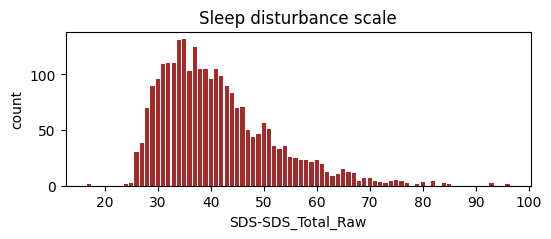

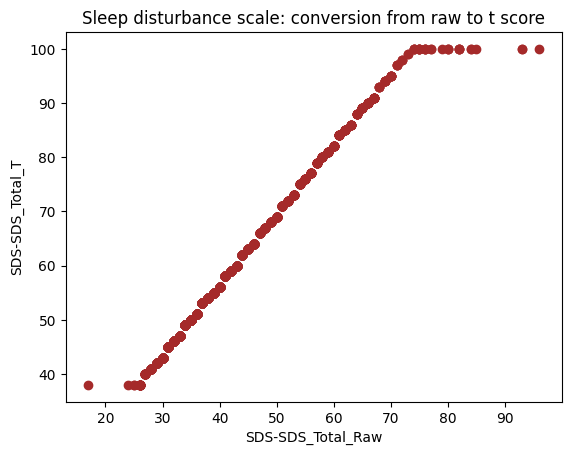

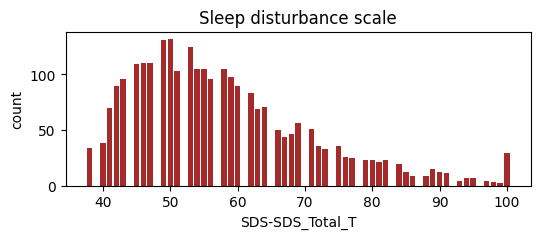

In [13]:
vc = train.get_column('SDS-SDS_Total_Raw').value_counts()
plt.figure(figsize=(6, 2))
plt.title('Sleep disturbance scale')
plt.bar(vc.get_column('SDS-SDS_Total_Raw'), vc.get_column('count'), color='brown')
plt.xlabel('SDS-SDS_Total_Raw')
plt.ylabel('count')
plt.show()

plt.title('Sleep disturbance scale: conversion from raw to t score')
plt.scatter(train.get_column('SDS-SDS_Total_Raw'),
            train.get_column('SDS-SDS_Total_T'),
            color='brown')
plt.xlabel('SDS-SDS_Total_Raw')
plt.ylabel('SDS-SDS_Total_T')
plt.show()

vc = train.get_column('SDS-SDS_Total_T').value_counts()
plt.figure(figsize=(6, 2))
plt.title('Sleep disturbance scale')
plt.bar(vc.get_column('SDS-SDS_Total_T'), vc.get_column('count'), color='brown')
plt.xlabel('SDS-SDS_Total_T')
plt.ylabel('count')
plt.show()


**Insight:** There are many outliers. We have to decide whether to keep them, modify them ([winsorizing](https://en.wikipedia.org/wiki/Winsorizing)) or drop them.

# Actigraphy files (time series)

> [Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. A small actigraph unit, also called an actimetry sensor, is worn for a week or more to measure gross motor activity. The unit is usually in a wristwatch-like package worn on the wrist. The movements the actigraph unit undergoes are continually recorded and some units also measure light exposure. (Wikipedia)

We have actigraphy files for a quarter of the participants (996 to be precise). The file name is always `part-0.parquet`. 

Looking at the file of participant `id=0417c91e`, a six-year old right-handed girl, we see that this participant started to use the accelerometer on a Tuesday (weekday=2) of the second quarter of the year at second 44100 of the day (12:15 PM), 5 days after the PCIAT test. She gave the accelerometer back on the 53rd day after the PCIAT test, a Monday of the third quarter, at 9:08 AM.

The competition data page says that `time_of_day` is in format `%H:%M:%S.%9f`. This is obviously not true. `time_of_day` is measured in nanoseconds since midnight.

In [14]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…
287174,-0.407433,0.091612,-0.377763,0.039733,-43.319416,0.0,7.0,3695.0,32875000000000,1,3,53.0
287175,-0.703572,0.016187,0.15956,0.03598,14.12139,0.0,7.0,3695.0,32880000000000,1,3,53.0
287176,-0.209607,-0.4697,0.636573,0.097799,44.998573,0.0,7.0,3695.0,32885000000000,1,3,53.0


We can plot diagrams of the time series in this file. What can we see?
1. We clearly see a daily pattern.
2. We see that the girl wore the accelerometer for 31 days and then took it off.
3. The dataset has a non-wear_flag column, but that flag is always zero for this participant. 
4. The girl is in an environment where the illuminance exceeds 2500 [lux](https://en.wikipedia.org/wiki/Lux) every day (the device cannot measure more than 2500 lux). Such a high illuminance means that she is outdoors or in a room with huge windows.
5. The girl moves a lot: she has enmo values above 2 almost every day.
6. The time series usually contain measurements every 5 seconds, but some time steps are missing. It is not documented under what conditions time steps are skipped.

**Insight:** 
- Use the ENMO and light columns and don't trust the non-wear_flag!
- The ENMO and light columns offer themselves for analysis with a one-dimensional convolutional neural network, but if we want to start simple, we can use some basic aggregations (mean, variance, ...) of the time series as features for a gradient-boosting model.


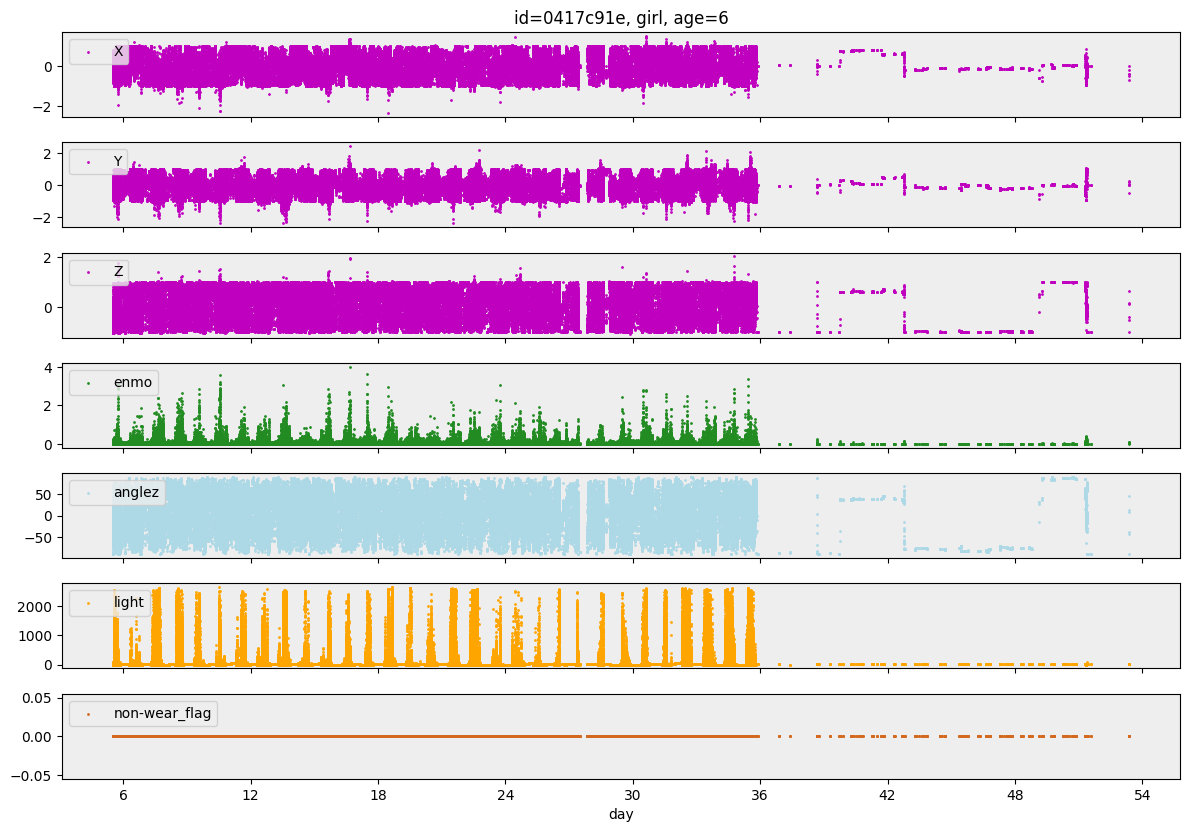

In [15]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

Let's look at a few more time series. The next time series covers only one day, I don't think it helps predict problematic Internet use:

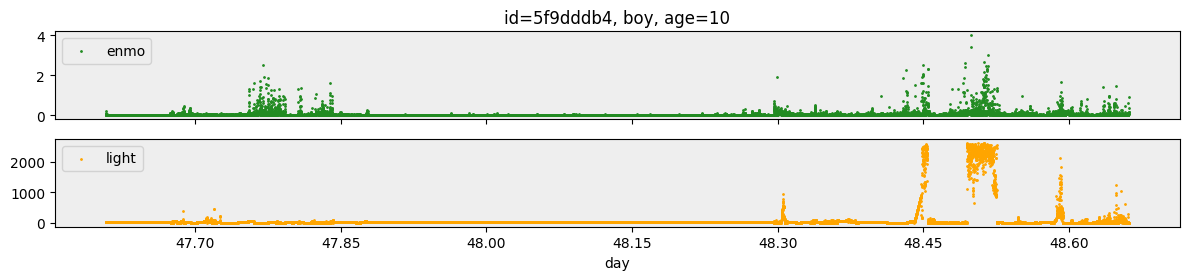

In [16]:
analyze_actigraphy('5f9dddb4', small=True)

Our next participant, a 15-year old left-handed boy, never moves much (enmo < 0.5), and he saw daylight only once in a whole month:

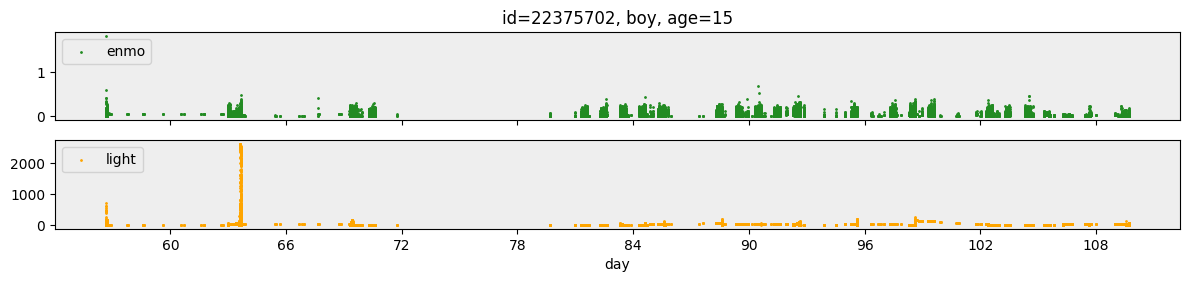

In [17]:
analyze_actigraphy('22375702', small=True)

Next one: This poor nine-year old boy (id 0668373f) had a quiet life for two and a half weeks, then he had an accident with an acceleration of 12 g. After the accident, the device immediately stopped recording data; let's hope that the boy survived!

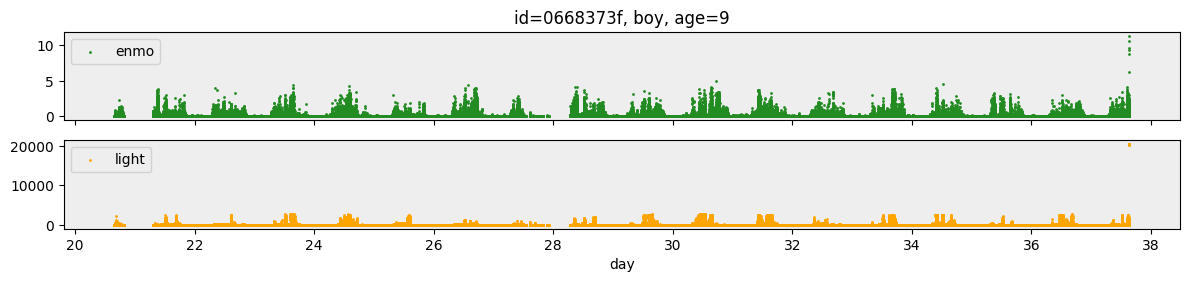

In [18]:
analyze_actigraphy('0668373f', small=True)

Our last time series shows some strange ramps in the illuminance measurement. It looks like there was missing data and somebody filled the blanks by linear interpolation. I'd prefer to get the raw data without undocumented preprocessing applied.

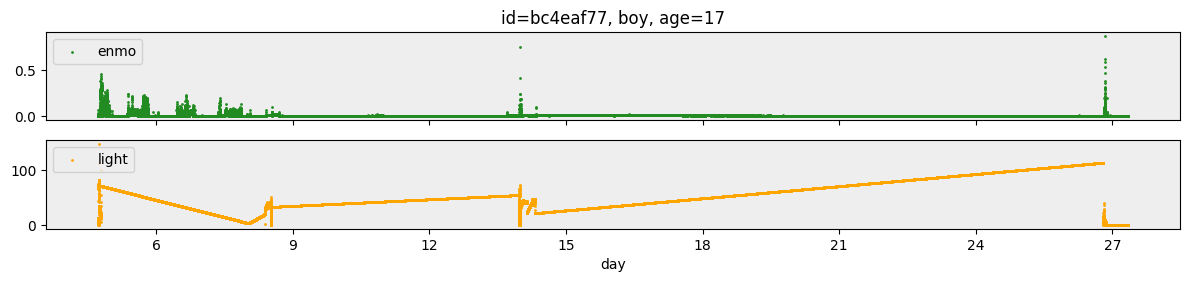

In [19]:
analyze_actigraphy('bc4eaf77', small=True)

**Insight:** We need a lot of data cleaning before we can use the actigraphy data.

Did you notice that for some participants I mentioned whether they were right- or left-handed? Did you wonder how I came to that conclusion? It's simple. The actigraphy device is fixed to the wrist of the non-dominant arm. Depending on the whether you choose the left or right wrist, the X coordinate of the accelerometer will return a positive or negative average.

# A simple classification model

We can model the competition as a multiclass classification task with the four classes 'None', 'Mild', 'Moderate', 'Severe'. 

It is important that we select only the samples where the target `sii` is known and that we drop all PCIAT columns. We don't use the accelerometer data for this simple model.

We use the [scikit-learn implementation of the quadratic kappa score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) for evaluation. 

In [20]:
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof = np.zeros(len(y), dtype=int)
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = lightgbm.LGBMClassifier(verbose=-1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred
    
score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (classification with LightGBM){Style.RESET_ALL}")


# Fold 0: score=0.354
# Fold 1: score=0.350
# Fold 2: score=0.256
# Fold 3: score=0.317
# Fold 4: score=0.379
# Overall: score=0.331 (classification with LightGBM)


The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) helps understand the output of the model.

> Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class \[...\]. The diagonal of the matrix therefore represents all instances that are correctly predicted. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another). (Wikipedia)

The most common mislabeling of our classification model is indicated by the highest non-diagonal entry of the confusion matrix: It classifies the mildly problematic Internet use of 454 children as non-problematic.

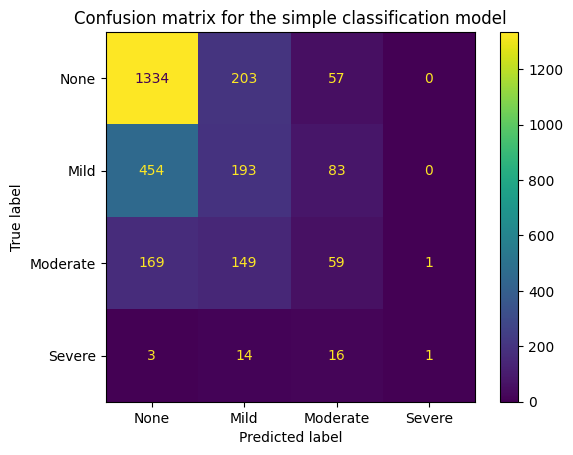

In [21]:
ConfusionMatrixDisplay.from_predictions(y, oof)
plt.title('Confusion matrix for the simple classification model')
plt.xticks(np.arange(4), target_labels)
plt.yticks(np.arange(4), target_labels)
plt.show()

# A simple regression model is better

We can use a regression model as well, and it turns out that the regression model is better than the classification model (it gets the higher cv score). We interpret the target as a number from 0 to 3, and we round the predictions of the regression model to the nearest integer.

In [22]:
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof_raw = np.zeros(len(y), dtype=float) # oof predictions, before rounding
oof = np.zeros(len(y), dtype=int) # oof predictions, rounded
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]

    model = lightgbm.LGBMRegressor(verbose=-1)
    model.fit(X_tr, y_tr.to_numpy())
    y_pred = model.predict(X_va)
    oof_raw[idx_va] = y_pred
    y_pred = y_pred.round(0).astype(int)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred

score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (regression with LightGBM){Style.RESET_ALL}")


# Fold 0: score=0.360
# Fold 1: score=0.422
# Fold 2: score=0.355
# Fold 3: score=0.384
# Fold 4: score=0.426
# Overall: score=0.389 (regression with LightGBM)


The confusion matrix shows that our regression model never predicts the class 'Severe' (the rightmost column of the matrix is zero):

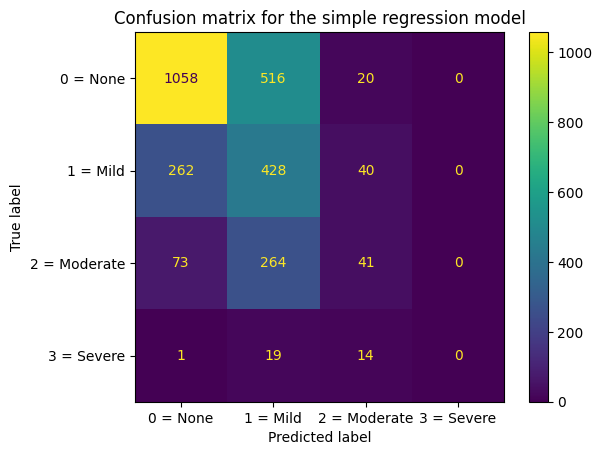

In [23]:
regression_labels = [f"{i} = {target_labels[i]}" for i in range(4)]

ConfusionMatrixDisplay.from_predictions(y, oof)
plt.title('Confusion matrix for the simple regression model')
plt.xticks(np.arange(4), regression_labels)
plt.yticks(np.arange(4), regression_labels)
plt.show()

# Tuning the thresholds

Our regression model predicts float values, and in the previous section of this notebook, we rounded these float values to integers because the Kaggle competition expects integer predictions.

There is no reason why rounding the float values to the integers 0, 1, 2 and 3 at the thresholds 0.5, 1.5 and 2.5 should give the best score. We can easily find thresholds which lead to a higher score, and the improvement is substantial:


# Optimized thresholds: [0.6  1.07 2.52]
# Score with default rounding:     0.389
# Score with optimized thresholds: 0.436


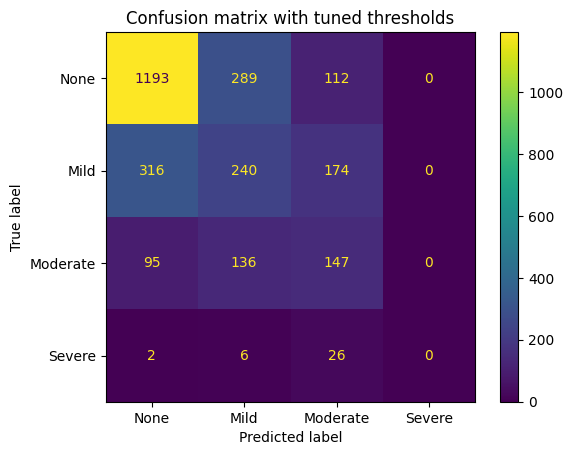

In [24]:
def round_with_thresholds(raw_preds, thresholds):
    """Round the raw predictions using specified thresholds
    
    Parameters
    ----------
    raw_preds: raw predictions of the regressor, array of n_samples float values
    thresholds: 3-element float array
    
    Returns
    -------
    rounded_preds: rounded predictions, array of n_samples int values in range 0..3
    """
    return np.where(raw_preds < thresholds[0], 0,
                    np.where(raw_preds < thresholds[1], 1,
                             np.where(raw_preds < thresholds[2], 2, 3)))


def fun(thresholds, y_true, raw_preds):
    """Function to be minimized: negative quadratic kappa score
    
    Parameters:
    thresholds: ndarray of shape (3, )
    y_true: ndarray of shape (n_samples, )
    raw_preds: ndarray of shape (n_samples, )
    
    Returns:
    negative quadratic kappa score for the predictions rounded at the specified thresholds
    """
    rounded_preds = round_with_thresholds(raw_preds, thresholds)
    return - cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

# Determine the thresholds which give the highest quadratic kappa score
res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y, oof_raw), method='Nelder-Mead')
assert res.success
oof_tuned = round_with_thresholds(oof_raw, res.x)
print(f"# Optimized thresholds: {res.x.round(2)}")
print(f"# Score with default rounding:     {cohen_kappa_score(y, oof, weights='quadratic'):.3f}")
print(f"# Score with optimized thresholds: {cohen_kappa_score(y, oof_tuned, weights='quadratic'):.3f}")

ConfusionMatrixDisplay.from_predictions(y, oof_tuned)
plt.title('Confusion matrix with tuned thresholds')
plt.xticks(np.arange(4), target_labels)
plt.yticks(np.arange(4), target_labels)
plt.show()